### XGBoost_Pred_24OUT2020_AD_dfa2_K40_tunning

## bibliotecas a serem usadas

In [1]:
import plotly_express as px
# biblioteca nova, para visualização com diferentes formas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import scipy
import seaborn as sns
import statsmodels
import statsmodels.stats.api as sms

In [2]:
# parâmetros dos gráficos para o arquivo
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

%matplotlib inline
plt.rcParams.update(params)

### arquivo_dados_formatados_agrupados

In [3]:
df=pd.read_csv('d_f_a_2.csv',encoding = "ISO-8859-1", sep=";", low_memory=False, nrows=1000000)
# somente 100 mil linhas, tempo computação adequável

In [4]:
df.head(3)

cod_muni  qtd_mora  incidencia diag_princ  prevalencia  renda_media_mora  \
0    290010      8301           1        J04     0.000121          0.103943   
1    290010      8301           1        J06     0.000121          0.103943   
2    290010      8301           5        J15     0.000602          0.103943   

   SITU1_entorno  SITU2_entorno  SITU3_entorno  SITU4_entorno  ...  \
0       0.463481            0.0            0.0            0.0  ...   
1       0.463481            0.0            0.0            0.0  ...   
2       0.463481            0.0            0.0            0.0  ...   

   V032_domicilio02  V033_domicilio02  V034_domicilio02  V035_domicilio02  \
0          0.005892           0.39911          0.016835          0.035354   
1          0.005892           0.39911          0.016835          0.035354   
2          0.005892           0.39911          0.016835          0.035354   

   V036_domicilio02  V037_domicilio02  V038_domicilio02  V041_domicilio02  \
0               0.0          0.010582          0.970779          0.027417   
1               0.0          0.010582          0.970779          0.027417   
2               0.0          0.010582          0.970779          0.027417   

   V045_domicilio02  V089_domicilio02  
0          0.490861          0.509139  
1          0.490861          0.509139  
2          0.490861          0.509139  

[3 rows x 83 columns]

### Doença mais frequente = K40

In [5]:
# separação na doença mais frequente desse arquivo = K40
temp = np.where(df['diag_princ'].isin(['K40']))
df40 = df.loc[temp]
# reunir tudo
df40.head(3)

cod_muni  qtd_mora  incidencia diag_princ  prevalencia  renda_media_mora  \
18    290010      8301          24        K40     0.002891          0.103943   
53    290020     16991          50        K40     0.002943          0.036980   
98    290030     14503          97        K40     0.006688          0.063205   

    SITU1_entorno  SITU2_entorno  SITU3_entorno  SITU4_entorno  ...  \
18       0.463481            0.0            0.0            0.0  ...   
53       0.548910            0.0            0.0            0.0  ...   
98       0.887555            0.0            0.0            0.0  ...   

    V032_domicilio02  V033_domicilio02  V034_domicilio02  V035_domicilio02  \
18          0.005892          0.399110          0.016835          0.035354   
53          0.109294          0.194620          0.004395          0.249180   
98          0.006756          0.374053          0.024022          0.037399   

    V036_domicilio02  V037_domicilio02  V038_domicilio02  V041_domicilio02  \
18          0.000000          0.010582          0.970779          0.027417   
53          0.000176          0.024848          0.909341          0.086381   
98          0.000409          0.006142          0.970859          0.018904   

    V045_domicilio02  V089_domicilio02  
18          0.490861          0.509139  
53          0.501875          0.498125  
98          0.491913          0.508087  

[3 rows x 83 columns]

## XGBOOST_Predição

In [6]:
!pip install xgboost

In [7]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### arquivo_preparo

In [10]:
# Preparação dos arquivos de entrada (X) e saída (y)
X = df40[['cod_muni','SITU1_entorno','SITU5_entorno','renda_media_mora','V032_domicilio02','V034_domicilio02','V035_domicilio02']]
y = df40.loc[:,'prevalencia']

In [11]:
X.head(2)

cod_muni  SITU1_entorno  SITU5_entorno  renda_media_mora  \
18    290010       0.463481       0.083528          0.103943   
53    290020       0.548910       0.127955          0.036980   

    V032_domicilio02  V034_domicilio02  V035_domicilio02  
18          0.005892          0.016835          0.035354  
53          0.109294          0.004395          0.249180

In [12]:
y.head(2)

18    0.002891
53    0.002943
Name: prevalencia, dtype: float64

In [13]:
# Divisão entre arquivos de treino e teste, com corte em 30%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.3, random_state=1234)

### Baseline

In [14]:
# regressor com ajuste inicial
regressor = xgb.XGBRegressor(learning_rate=0.1,
                             subsample=1,colsample_bytree=1,n_estimators=1000,
                             reg_lambda=1,gamma=1,max_depth=3,missing=0.01)

In [15]:
# preparação do regressor
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=0.01, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [16]:
y_pred = regressor.predict(X_test)

In [17]:
y_pred

array([0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484768,
       0.00484768, 0.00484768, 0.00484768, 0.00484768, 0.00484

In [18]:
mean_squared_error(y_test, y_pred)

4.979770575507606e-06

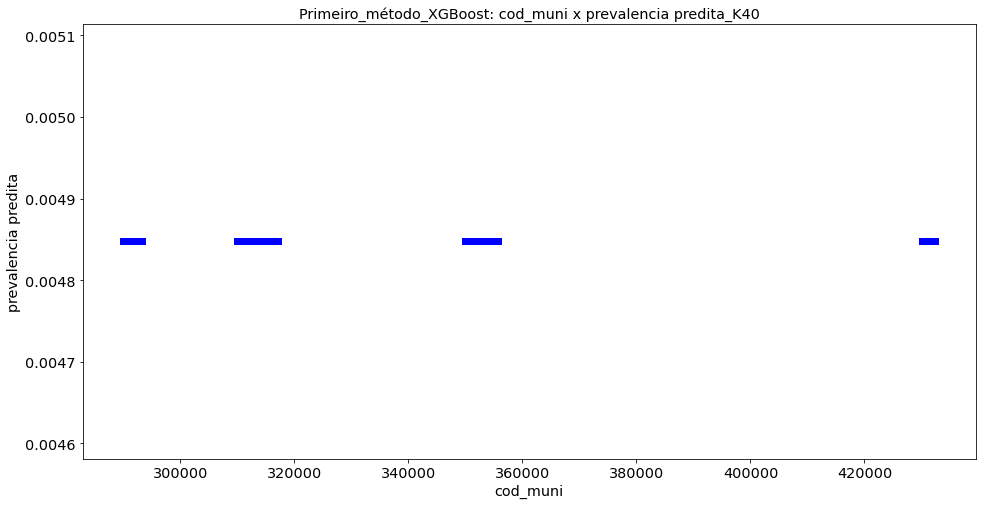

In [19]:
plt.scatter(X_test['cod_muni'], y_pred, c = "blue", marker = "s")
plt.title("Primeiro_método_XGBoost: cod_muni x prevalencia predita_K40")
plt.xlabel("cod_muni")
plt.ylabel("prevalencia predita")
plt.show()

In [20]:
errop1= (y_test - y_pred)*100/y_test
# em porcentagem

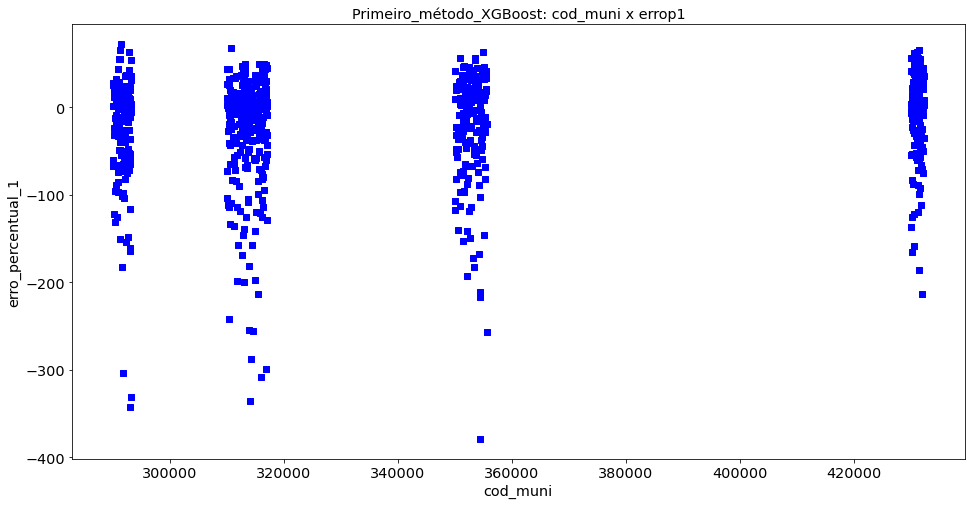

In [21]:
plt.scatter(X_test['cod_muni'], errop1, c = "blue", marker = "s")
plt.title("Primeiro_método_XGBoost: cod_muni x errop1")
plt.xlabel("cod_muni")
plt.ylabel("erro_percentual_1")
plt.show()

### Otimização método XGBoost

In [22]:
params= {
    'booster': ["gbtree","gblinear",'dart'],
    'learning rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max depth': [3,4,5,8,10,11,12],
    'min_child_weigth': [1,3,5,7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.6]
}

In [23]:
regressor = xgb.XGBRegressor()

In [24]:
random_search = RandomizedSearchCV(regressor,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [25]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    8.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.8s finished


[14:58:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { learning rate, max depth, min_child_weigth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_con...
                   iid='warn', n_iter=5, n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear',
                                                    'dart'],
                                        'colsa

In [26]:
print(random_search.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning rate=0.05, learning_rate=0.300000012, max depth=10,
             max_delta_step=0, max_depth=6, min_child_weight=1,
             min_child_weigth=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [27]:
random_search.best_params_

{'min_child_weigth': 5,
 'max depth': 10,
 'learning rate': 0.05,
 'gamma': 0.4,
 'colsample_bytree': 0.3,
 'booster': 'gbtree'}

In [28]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(regressor,X,y,cv=10)

In [29]:
modelb = xgb.XGBRegressor(colsample_bytree=0.6,
                 gamma=0,                 
                 learning_rate=0.2,
                 max_depth=5,
                 min_child_weight=1,
                 n_estimators=100,                                                                    
                 reg_alpha=0,
                 reg_lambda=1,
                 subsample=1,
                 seed=42, booster = 'dart') 

In [30]:
modelb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
y_pred_2 = modelb.predict(X_test)

In [32]:
mean_squared_error(y_test, y_pred_2)

4.966916045057161e-06

In [33]:
errop2= (y_test - y_pred_2)*100/y_test
# em porcentagem

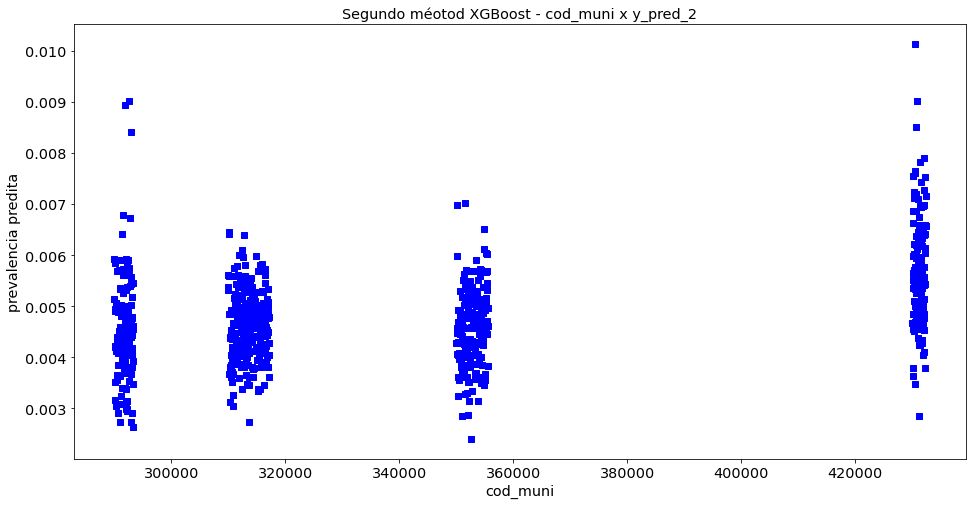

In [34]:
plt.scatter(X_test['cod_muni'], y_pred_2, c = "blue", marker = "s")
plt.title("Segundo méotod XGBoost - cod_muni x y_pred_2")
plt.xlabel("cod_muni")
plt.ylabel("prevalencia predita")
plt.show()

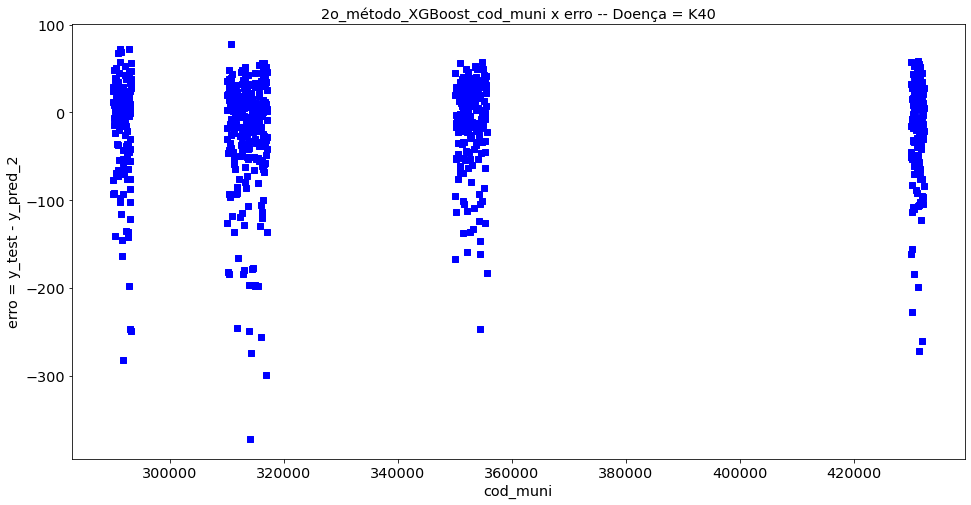

In [35]:
plt.scatter(X_test['cod_muni'], errop2, c = "blue", marker = "s")
plt.title("2o_método_XGBoost_cod_muni x erro -- Doença = K40")
plt.xlabel("cod_muni")
plt.ylabel("erro = y_test - y_pred_2")
plt.show()

### Comparação dos erros percentuais

In [36]:
comp = errop2/errop1
# errop2 - otimização com dart
# errop1 - baseline (caso mais simples)

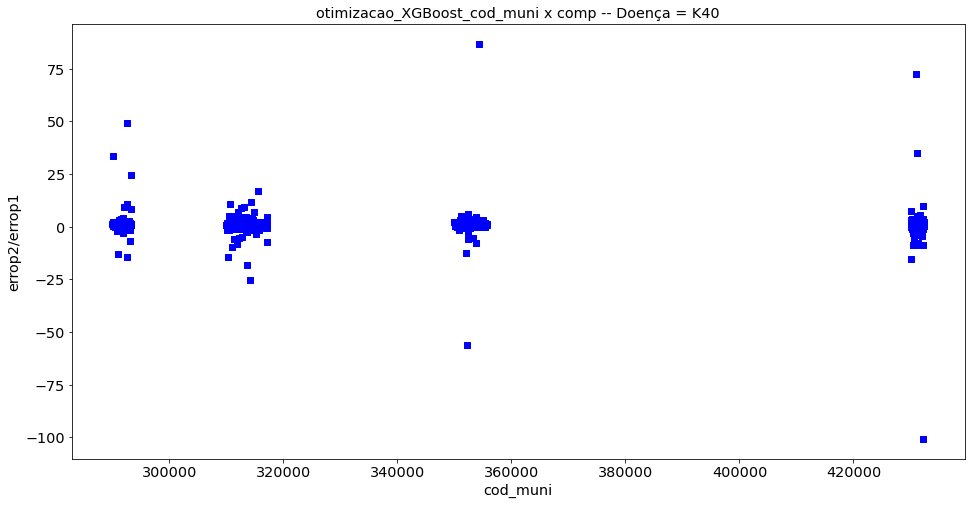

In [37]:
plt.scatter(X_test['cod_muni'], comp, c = "blue", marker = "s")
plt.title("otimizacao_XGBoost_cod_muni x comp -- Doença = K40")
plt.xlabel("cod_muni")
plt.ylabel("errop2/errop1")
plt.show()